In [ ]:
pip install --upgrade tensorflow


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import random as rn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Variables globales
Imagenes = []
Etiquetas = []
IMG_TAM = 224  # Tamaño de las imágenes para VGG16
DIR_BASE = '/content/drive/MyDrive/TT/Imagenes clasificadas'
DIR_ENFERMO_SR = DIR_BASE + '/Enfermo/Stem end Rot'
DIR_ENFERMO_BR = DIR_BASE + '/Enfermo/Body rot'
DIR_SANO = DIR_BASE + '/Sano'

In [ ]:
# Función para obtener extensiones de archivos
def obtener_extension_archivos(DIR):
    ext = []
    for archivo in os.listdir(DIR):
        nom_archivo, ext_archivo = os.path.splitext(archivo)
        ext.append(ext_archivo)
    extensiones = set(ext)
    print(extensiones)

# Función para validar imágenes
def imagen_valida(archivo, extensiones=[".jpg", ".png", ".JPG", ".PNG", ".jfif", ".jpeg"]):
    nom_archivo, ext_archivo = os.path.splitext(archivo)
    es_archivo = os.path.isfile(archivo)
    es_imagen = ext_archivo.lower() in extensiones
    return es_archivo and es_imagen

In [ ]:
# Obtener extensiones
obtener_extension_archivos(DIR_ENFERMO_SR)
obtener_extension_archivos(DIR_ENFERMO_BR)
obtener_extension_archivos(DIR_SANO)

{'.jpg', '.JPG', '.jpeg', '.PNG', '.webp', '.png', '.jfif'}
{'.jpg', '.JPG', '.jpeg', '.PNG', '.jfif'}
{'', '.jpg', '.JPG', '.jpeg', '.avif', '.jfif'}


In [ ]:
# Función para construir la base de datos
def construir_base_datos(etiqueta, DIR):
    for archivo in tqdm(os.listdir(DIR)):
        ruta = os.path.join(DIR, archivo)
        if imagen_valida(ruta):
            img = tf.keras.preprocessing.image.load_img(ruta, color_mode='rgb')
            matriz_img = tf.keras.preprocessing.image.img_to_array(img)
            matriz_img = tf.image.resize(matriz_img / 255, [IMG_TAM, IMG_TAM])  # Cambiar tamaño a 224x224
            Imagenes.append(matriz_img.numpy())
            Etiquetas.append(etiqueta)

In [ ]:
# Etiquetas de las clases
clases = ['Sano', 'Enfermo_BODYROT', 'Enfermo_STEMENDROT']
construir_base_datos(0, DIR_SANO)
print('\n', len(Etiquetas))
construir_base_datos(1, DIR_ENFERMO_BR)
print('\n', len(Etiquetas))
construir_base_datos(2, DIR_ENFERMO_SR)
print('\n', len(Etiquetas))

# Codificar las etiquetas
codificadorEtiquetas = LabelEncoder()
claveEtiquetas = codificadorEtiquetas.fit_transform(Etiquetas)

# Convertir a one-hot
claveEtiquetas = tf.keras.utils.to_categorical(claveEtiquetas, num_classes=len(clases))

100%|██████████| 126/126 [00:30<00:00,  4.09it/s]



 101


100%|██████████| 34/34 [00:10<00:00,  3.31it/s]



 135


100%|██████████| 68/68 [00:16<00:00,  4.20it/s]


 201


In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
img_entrenamiento, img_prueba, etq_entrenamiento, etq_prueba = train_test_split(
    Imagenes, claveEtiquetas, test_size=0.2, random_state=42)

# Convertir las imágenes a un arreglo numpy
img_entrenamiento = np.array(img_entrenamiento)
img_prueba = np.array(img_prueba)

In [ ]:
# Crear el modelo VGG16
from tensorflow.keras.applications import VGG16

modelo = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_TAM, IMG_TAM, 3))
modelo.trainable = False  # Congelar las capas de VGG16

# Agregar capas adicionales
x = tf.keras.layers.Flatten()(modelo.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
salida = tf.keras.layers.Dense(len(clases), activation='softmax')(x)  # 3 clases

modelo = tf.keras.Model(inputs=modelo.input, outputs=salida)

# Compilar el modelo usando categorical_crossentropy
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Entrenar el modelo
historial = modelo.fit(img_entrenamiento, etq_entrenamiento,
                        validation_data=(img_prueba, etq_prueba),
                        epochs=10, batch_size=32)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 115s 23s/step - accuracy: 0.4019 - loss: 3.2296 - val_accuracy: 0.6098 - val_loss: 1.2724
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 144s 24s/step - accuracy: 0.7172 - loss: 1.2704 - val_accuracy: 0.7317 - val_loss: 0.5989
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 139s 23s/step - accuracy: 0.8201 - loss: 0.8841 - val_accuracy: 0.8537 - val_loss: 0.5707
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 141s 23s/step - accuracy: 0.9212 - loss: 0.2295 - val_accuracy: 0.8537 - val_loss: 0.5828
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 111s 23s/step - accuracy: 0.9318 - loss: 0.1967 - val_accuracy: 0.8780 - val_loss: 0.6292
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 148s 25s/step - accuracy: 0.9359 - loss: 0.1243 - val_accuracy: 0.8780 - val_loss: 0.5820
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 137s 24s/step - accuracy: 0.9667 - loss: 0.0973 - val_accuracy: 0.8537 - val_loss: 0.5776
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 160s 28s/step - accuracy: 0.9707 - loss: 0.0657 - val_accuracy: 0.9024 - val_loss:

In [ ]:
# Generar predicciones
predicciones = modelo.predict(img_prueba)
predicciones_etq = np.argmax(predicciones, axis=1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step


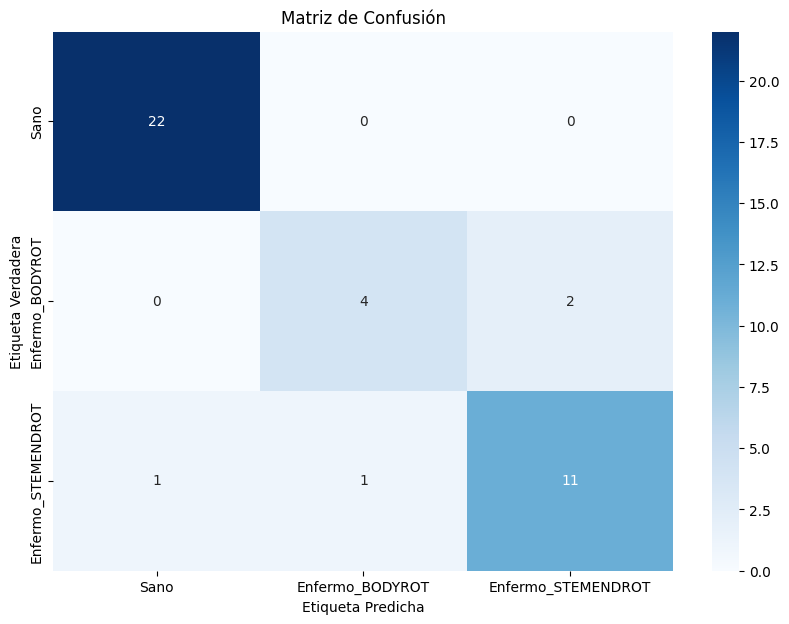

In [ ]:
# Obtener las etiquetas verdaderas
etq_verdaderas = np.argmax(etq_prueba, axis=1)  # Convertir de one-hot a etiquetas enteras

# Generar matriz de confusión
conf_matrix = confusion_matrix(etq_verdaderas, predicciones_etq)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()